In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [8]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [9]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [10]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [11]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [12]:
DEFAULT_BETA_BJORCK = 0.5
DEFAULT_EPS_SPECTRAL = 1e-3
DEFAULT_EPS_BJORCK = 1e-3
DEFAULT_MAXITER_BJORCK = 15
DEFAULT_MAXITER_SPECTRAL = 10
SWAP_MEMORY = True
STOP_GRAD_SPECTRAL = True

def reshaped_kernel_orthogonalization(
    kernel,
    u,
    adjustment_coef,
    eps_spectral=DEFAULT_EPS_SPECTRAL,
    eps_bjorck=DEFAULT_EPS_BJORCK,
    beta=DEFAULT_BETA_BJORCK,
    maxiter_spectral=DEFAULT_MAXITER_SPECTRAL,
    maxiter_bjorck=DEFAULT_MAXITER_BJORCK,
):
    """
    Perform reshaped kernel orthogonalization (RKO) to the kernel given as input. It
    apply the power method to find the largest singular value and apply the Bjorck
    algorithm to the rescaled kernel. This greatly improve the stability and and
    speed convergence of the bjorck algorithm.

    Args:
        kernel (tf.Tensor): the kernel to orthogonalize
        u (tf.Tensor): the vector used to do the power iteration method
        adjustment_coef (float): the adjustment coefficient as used in convolution
        eps_spectral (float): stopping criterion in spectral algorithm
        eps_bjorck (float): stopping criterion in bjorck algorithm
        beta (float): the beta used in the bjorck algorithm
        maxiter_spectral (int): maximum number of iterations for the power iteration
        maxiter_bjorck (int): maximum number of iterations for bjorck algorithm

    Returns:
        tf.Tensor: the orthogonalized kernel, the new u, and sigma which is the largest
            singular value

    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """
    W_shape = kernel.shape
    # Flatten the Tensor
    W_reshaped = tf.reshape(kernel, [-1, W_shape[-1]])
    W_bar, u, sigma = spectral_normalization(
        W_reshaped, u, eps=eps_spectral, maxiter=maxiter_spectral
    )
    if (eps_bjorck is not None) and (beta is not None):
        W_bar = bjorck_normalization(
            W_bar, eps=eps_bjorck, beta=beta, maxiter=maxiter_bjorck
        )
    W_bar = W_bar * adjustment_coef
    W_bar = K.reshape(W_bar, kernel.shape)
    return W_bar, u, sigma


def _wwtw(w):
    if w.shape[0] > w.shape[1]:
        return w @ (tf.transpose(w) @ w)
    else:
        return (w @ tf.transpose(w)) @ w


def bjorck_normalization(
    w, eps=DEFAULT_EPS_BJORCK, beta=DEFAULT_BETA_BJORCK, maxiter=DEFAULT_MAXITER_BJORCK
):
    """
    apply Bjorck normalization on w.

    Args:
        w (tf.Tensor): weight to normalize, in order to work properly, we must have
            max_eigenval(w) ~= 1
        eps (float): epsilon stopping criterion: norm(wt - wt-1) must be less than eps
        beta (float): beta used in each iteration, must be in the interval ]0, 0.5]
        maxiter (int): maximum number of iterations for the algorithm

    Returns:
        tf.Tensor: the orthonormal weights

    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """
    # create a fake old_w that does'nt pass the loop condition
    # it won't affect computation as the first action done in the loop overwrite it.
    old_w = 10 * w
    # define the loop condition

    def cond(w, old_w):
        return tf.linalg.norm(w - old_w) >= eps

    # define the loop body
    def body(w, old_w):
        old_w = w
        w = (1 + beta) * w - beta * _wwtw(w)
        return w, old_w

    # apply the loop
    w, old_w = tf.while_loop(
        cond,
        body,
        (w, old_w),
        parallel_iterations=30,
        maximum_iterations=maxiter,
        swap_memory=SWAP_MEMORY,
    )
    return w


def _power_iteration(
    linear_operator,
    adjoint_operator,
    u,
    eps=DEFAULT_EPS_SPECTRAL,
    maxiter=DEFAULT_MAXITER_SPECTRAL,
    axis=None,
):
    """Internal function that performs the power iteration algorithm to estimate the
    largest singular vector of a linear operator.

    Args:
        linear_operator (Callable): a callable object that maps a linear operation.
        adjoint_operator (Callable): a callable object that maps the adjoint of the
            linear operator.
        u (tf.Tensor): initialization of the singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.
        axis (int/list, optional): dimension along which to normalize. Can be set for
            depthwise convolution for example. Defaults to None.

    Returns:
        tf.Tensor: the maximum singular vector.
        
    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """

    # Prepare while loop variables
    u = tf.math.l2_normalize(u, axis=axis)
    # create a fake old_w that doesn't pass the loop condition, it will be overwritten
    old_u = u + 2 * eps

    # Loop body
    def body(u, old_u):
        old_u = u
        v = linear_operator(u)
        u = adjoint_operator(v)

        u = tf.math.l2_normalize(u, axis=axis)

        return u, old_u

    # Loop stopping condition
    def cond(u, old_u):
        return tf.linalg.norm(u - old_u) >= eps

    # Run the while loop
    u, _ = tf.while_loop(
        cond,
        body,
        (u, old_u),
        maximum_iterations=maxiter,
        swap_memory=SWAP_MEMORY,
    )

    # Prevent gradient to back-propagate into the while loop
    if STOP_GRAD_SPECTRAL:
        u = tf.stop_gradient(u)

    return u


def spectral_normalization(
    kernel, u, eps=DEFAULT_EPS_SPECTRAL, maxiter=DEFAULT_MAXITER_SPECTRAL
):
    """
    Normalize the kernel to have its maximum singular value equal to 1.

    Args:
        kernel (tf.Tensor): the kernel to normalize, assuming a 2D kernel.
        u (tf.Tensor): initialization of the maximum singular vector.
        eps (float, optional): stopping criterion of the algorithm, when
            norm(u[t] - u[t-1]) is less than eps. Defaults to DEFAULT_EPS_SPECTRAL.
        maxiter (int, optional): maximum number of iterations for the algorithm.
            Defaults to DEFAULT_MAXITER_SPECTRAL.

    Returns:
        the normalized kernel, the maximum singular vector, and the maximum singular
            value.
            
    Reference:
        Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
        Achieving robustness in classification using optimal transport with hinge regularization. 
        In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).
        
    """

    if u is None:
        u = tf.random.uniform(
            shape=(1, kernel.shape[-1]), minval=0.0, maxval=1.0, dtype=kernel.dtype
        )

    def linear_op(u):
        return u @ tf.transpose(kernel)

    def adjoint_op(v):
        return v @ kernel

    u = _power_iteration(linear_op, adjoint_op, u, eps, maxiter)

    # Compute the largest singular value and the normalized kernel.
    # We assume that in the worst case we converged to sigma + eps (as u and v are
    # normalized after each iteration)
    # In order to be sure that operator norm of normalized kernel is strictly less than
    # one we use sigma + eps, which ensures stability of Björck algorithm even when
    # beta=0.5
    sigma = tf.reshape(tf.norm(linear_op(u)), (1, 1))
    normalized_kernel = kernel / (sigma + eps)
    return normalized_kernel, u, sigma

In [13]:
class SpectralConstraint(Constraint):
    def __init__(
        self,
        k_coef_lip=1.0,
        eps_spectral=DEFAULT_EPS_SPECTRAL,
        eps_bjorck=DEFAULT_EPS_BJORCK,
        beta_bjorck=DEFAULT_BETA_BJORCK,
        u=None,
    ) -> None:
        
        """
        Ensure that *all* singular values of the weight matrix equals to 1. Computation
        based on Bjorck algorithm. The computation is done in two steps:

        1. reduce the larget singular value to k_coef_lip, using iterate power method.
        2. increase other singular values to k_coef_lip, using bjorck algorithm.

        Args:
            k_coef_lip (float): lipschitz coefficient of the weight matrix
            eps_spectral (float): stopping criterion for the iterative power algorithm.
            eps_bjorck (float): stopping criterion Bjorck algorithm.
            beta_bjorck (float): beta parameter in bjorck algorithm.
            u (tf.Tensor): vector used for iterated power method, can be set to None
                (used for serialization/deserialization purposes).
                
        Reference:
            Serrurier, M., Mamalet, F., González-Sanz, A., Boissin, T., Loubes, J. M., & Del Barrio, E. (2021). 
            Achieving robustness in classification using optimal transport with hinge regularization. 
            In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 505-514).

        """
        
        self.eps_spectral = eps_spectral
        self.eps_bjorck = eps_bjorck
        self.beta_bjorck = beta_bjorck
        self.k_coef_lip = k_coef_lip
        if not (isinstance(u, tf.Tensor) or (u is None)):
            u = tf.convert_to_tensor(u)
        self.u = u
        super(SpectralConstraint, self).__init__()

    def __call__(self, w):
        # make the largest singular value of W to be 1
        wbar, _, _ = reshaped_kernel_orthogonalization(
            w,
            self.u,
            self.k_coef_lip,
            self.eps_spectral,
            self.eps_bjorck,
            self.beta_bjorck,
        )

        # clip to ensure non-negative weight
        wbar = K.clip(wbar, 0, wbar)
        return wbar

    def get_config(self):
        config = {
            "k_coef_lip": self.k_coef_lip,
            "eps_spectral": self.eps_spectral,
            "eps_bjorck": self.eps_bjorck,
            "beta_bjorck": self.beta_bjorck,
            "u": None if self.u is None else self.u.numpy(),
        }
        base_config = super(SpectralConstraint, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(10):
  num_dims = 4

  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

  # # define scalers for both X and y base on training data only
  scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
  scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

  X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
  y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

  y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

  # ICLRNN
  input = Input(shape=(X_train.shape[1],X_train.shape[2]))
  x = SimpleRNN(512, activation='relu', return_sequences=True, kernel_constraint=SpectralConstraint())(input)
  x = SimpleRNN(512, activation='relu', return_sequences=True, kernel_constraint=SpectralConstraint())(x)
  x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
  model = Model(input, x)
    
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
    
  training_loss[i] = history.history['val_loss'][-1]
  print(noise)
  print(training_loss)

  loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
  test_loss[i] = loss[0]
  print(test_loss)
    
  name = 'iclrnn_original_512_'
  name = name + str(noise[i]) + '.h5'
  model.save(name)

model.summary()

Epoch 1/200
26/26 - 102s - loss: 0.7776 - mean_squared_error: 0.7776 - val_loss: 0.5495 - val_mean_squared_error: 0.5495 - 102s/epoch - 4s/step
Epoch 2/200
26/26 - 5s - loss: 0.5294 - mean_squared_error: 0.5294 - val_loss: 0.5038 - val_mean_squared_error: 0.5038 - 5s/epoch - 202ms/step
Epoch 3/200
26/26 - 5s - loss: 0.4942 - mean_squared_error: 0.4942 - val_loss: 0.4750 - val_mean_squared_error: 0.4750 - 5s/epoch - 202ms/step
Epoch 4/200
26/26 - 5s - loss: 0.4666 - mean_squared_error: 0.4666 - val_loss: 0.4495 - val_mean_squared_error: 0.4495 - 5s/epoch - 205ms/step
Epoch 5/200
26/26 - 5s - loss: 0.4417 - mean_squared_error: 0.4417 - val_loss: 0.4258 - val_mean_squared_error: 0.4258 - 5s/epoch - 206ms/step
Epoch 6/200
26/26 - 5s - loss: 0.4185 - mean_squared_error: 0.4185 - val_loss: 0.4036 - val_mean_squared_error: 0.4036 - 5s/epoch - 211ms/step
Epoch 7/200
26/26 - 5s - loss: 0.3968 - mean_squared_error: 0.3968 - val_loss: 0.3829 - val_mean_squared_error: 0.3829 - 5s/epoch - 209ms/ste

Epoch 58/200
26/26 - 5s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - 5s/epoch - 208ms/step
Epoch 59/200
26/26 - 5s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - 5s/epoch - 207ms/step
Epoch 60/200
26/26 - 5s - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - 5s/epoch - 207ms/step
Epoch 61/200
26/26 - 5s - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 5s/epoch - 206ms/step
Epoch 62/200
26/26 - 5s - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - 5s/epoch - 205ms/step
Epoch 63/200
26/26 - 6s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - 6s/epoch - 225ms/step
Epoch 64/200
26/26 - 6s - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - 6s/epoch - 224

Epoch 115/200
26/26 - 5s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 5s/epoch - 195ms/step
Epoch 116/200
26/26 - 5s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - 5s/epoch - 188ms/step
Epoch 117/200
26/26 - 5s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 5s/epoch - 191ms/step
Epoch 118/200
26/26 - 5s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - 5s/epoch - 199ms/step
Epoch 119/200
26/26 - 5s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - 5s/epoch - 209ms/step
Epoch 120/200
26/26 - 5s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - 5s/epoch - 208ms/step
Epoch 121/200
26/26 - 5s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - 5s/epoc

Epoch 172/200
26/26 - 5s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - 5s/epoch - 202ms/step
Epoch 173/200
26/26 - 5s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - 5s/epoch - 210ms/step
Epoch 174/200
26/26 - 5s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.8666e-04 - val_mean_squared_error: 9.8666e-04 - 5s/epoch - 205ms/step
Epoch 175/200
26/26 - 5s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - 5s/epoch - 206ms/step
Epoch 176/200
26/26 - 5s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.9943e-04 - val_mean_squared_error: 9.9943e-04 - 5s/epoch - 209ms/step
Epoch 177/200
26/26 - 5s - loss: 9.2024e-04 - mean_squared_error: 9.2024e-04 - val_loss: 9.4275e-04 - val_mean_squared_error: 9.4275e-04 - 5s/epoch - 210ms/step
Epoch 178/200
26/26 - 5s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.0002e-04 - val_

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 115s - loss: 0.7678 - mean_squared_error: 0.7678 - val_loss: 0.5582 - val_mean_squared_error: 0.5582 - 115s/epoch - 4s/step
Epoch 2/200
26/26 - 7s - loss: 0.5397 - mean_squared_error: 0.5397 - val_loss: 0.5132 - val_mean_squared_error: 0.5132 - 7s/epoch - 266ms/step
Epoch 3/200
26/26 - 7s - loss: 0.5039 - mean_squared_error: 0.5039 - val_loss: 0.4839 - val_mean_squared_error: 0.4839 - 7s/epoch - 287ms/step
Epoch 4/200
26/26 - 7s - loss: 0.4759 - mean_squared_error: 0.4759 - val_loss: 0.4576 - val_mean_squared_error: 0.4576 - 7s/epoch - 259ms/step
Epoch 5/200
26/26 - 7s - loss: 0.4504 - mean_squared_error: 0.4504 - val_loss: 0.4338 - val_mean_squared_error: 0.4338 - 7s/epoch - 261ms/step
Epoch 6/200
26/26 - 7s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4115 - val_mean_squared_error: 0.4115 - 7s/epoch - 260ms/step
Epoch 7/200
26/26 - 7s - loss: 0.4054 - mean_squared_error: 0.4054 - val_loss: 0.3911 - val_mean_squared_error: 0.3911 - 7s/epoch - 264ms/ste

Epoch 58/200
26/26 - 7s - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - 7s/epoch - 260ms/step
Epoch 59/200
26/26 - 7s - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - 7s/epoch - 270ms/step
Epoch 60/200
26/26 - 7s - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - 7s/epoch - 268ms/step
Epoch 61/200
26/26 - 7s - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - 7s/epoch - 264ms/step
Epoch 62/200
26/26 - 7s - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - 7s/epoch - 273ms/step
Epoch 63/200
26/26 - 7s - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - 7s/epoch - 268ms/step
Epoch 64/200
26/26 - 7s - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - 7s/epoch - 279

Epoch 115/200
26/26 - 6s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 6s/epoch - 243ms/step
Epoch 116/200
26/26 - 6s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 6s/epoch - 243ms/step
Epoch 117/200
26/26 - 6s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 6s/epoch - 242ms/step
Epoch 118/200
26/26 - 6s - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 6s/epoch - 246ms/step
Epoch 119/200
26/26 - 6s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - 6s/epoch - 245ms/step
Epoch 120/200
26/26 - 6s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - 6s/epoch - 248ms/step
Epoch 121/200
26/26 - 6s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - 6s/epoc

Epoch 172/200
26/26 - 6s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - 6s/epoch - 240ms/step
Epoch 173/200
26/26 - 6s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - 6s/epoch - 240ms/step
Epoch 174/200
26/26 - 6s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - 6s/epoch - 241ms/step
Epoch 175/200
26/26 - 6s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - 6s/epoch - 241ms/step
Epoch 176/200
26/26 - 6s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - 6s/epoch - 242ms/step
Epoch 177/200
26/26 - 6s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - 6s/epoch - 245ms/step
Epoch 178/200
26/26 - 6s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - 6s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 49s - loss: 0.7686 - mean_squared_error: 0.7686 - val_loss: 0.5736 - val_mean_squared_error: 0.5736 - 49s/epoch - 2s/step
Epoch 2/200
26/26 - 6s - loss: 0.5603 - mean_squared_error: 0.5603 - val_loss: 0.5354 - val_mean_squared_error: 0.5354 - 6s/epoch - 217ms/step
Epoch 3/200
26/26 - 6s - loss: 0.5266 - mean_squared_error: 0.5266 - val_loss: 0.5068 - val_mean_squared_error: 0.5068 - 6s/epoch - 224ms/step
Epoch 4/200
26/26 - 5s - loss: 0.4992 - mean_squared_error: 0.4992 - val_loss: 0.4813 - val_mean_squared_error: 0.4813 - 5s/epoch - 210ms/step
Epoch 5/200
26/26 - 6s - loss: 0.4744 - mean_squared_error: 0.4744 - val_loss: 0.4578 - val_mean_squared_error: 0.4578 - 6s/epoch - 215ms/step
Epoch 6/200
26/26 - 6s - loss: 0.4512 - mean_squared_error: 0.4512 - val_loss: 0.4355 - val_mean_squared_error: 0.4355 - 6s/epoch - 216ms/step
Epoch 7/200
26/26 - 6s - loss: 0.4299 - mean_squared_error: 0.4299 - val_loss: 0.4156 - val_mean_squared_error: 0.4156 - 6s/epoch - 223ms/step


In [16]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [17]:
# ICLRNN with ReLU
# model.save('iclrnn_0.h5')
# model = tf.keras.models.load_model('iclrnn_original_256_0.h5', custom_objects={'SpectralConstraint': SpectralConstraint})

In [18]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 1s 40ms/step - loss: 0.0201 - mean_squared_error: 0.0201
test loss, test acc: [0.020093657076358795, 0.020093657076358795]


In [23]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

The FLOPs is:1599508
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 4)]           0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 10, 512)           264704    
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 10, 512)           524800    
                                                                 
 dense_9 (Dense)             (None, 10, 2)             1026      
                                                                 
Total params: 790530 (3.02 MB)
Trainable params: 790530 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


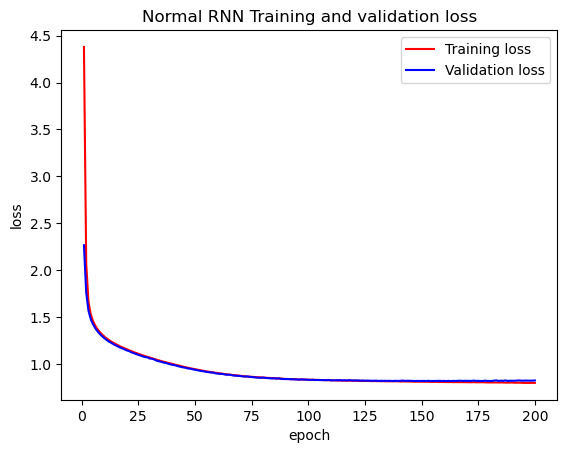

In [20]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_27604\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 2s 13ms/step
(3706, 10, 2)


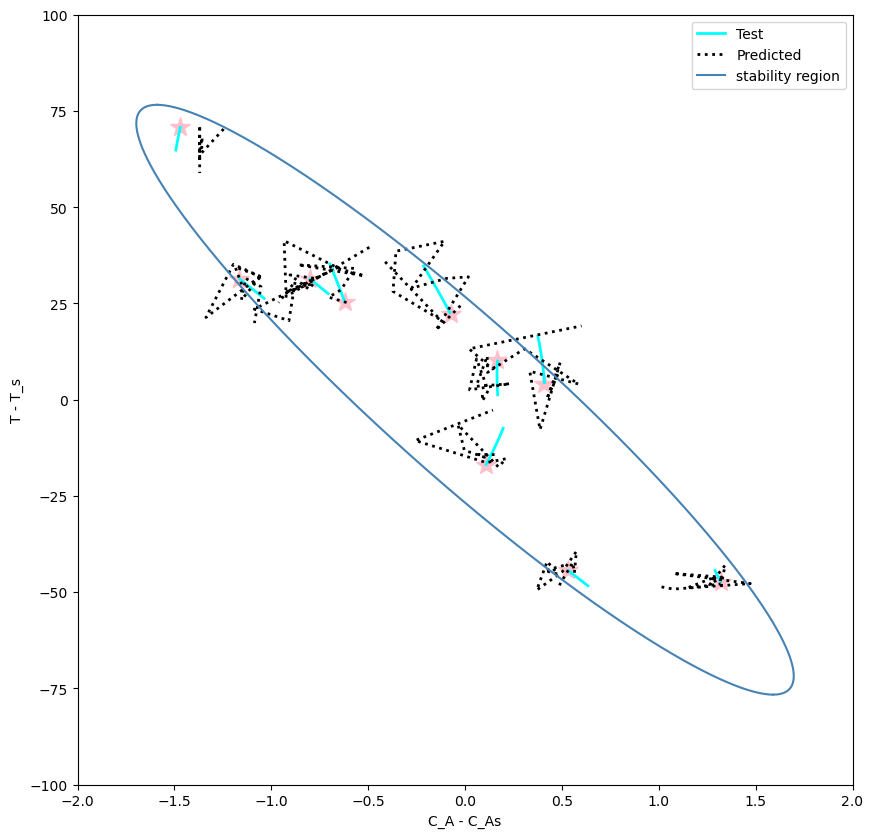

In [21]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()